# Imports and paths

In [1]:
import os
import sys

# root path
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the Python path
if ROOT not in sys.path:
    sys.path.append(ROOT)

import polars as pl
import pandas as pd
import numpy as np

In [2]:
from config import TRAIN_ENGINEERED_PATH, TEST_ENGINEERED_PATH
from src.data.loaders import PolarsLoader
from src.utils import filter_polars, timer

## Load train and test data

In [3]:
loader = PolarsLoader(sampling=True, file_type='parquet')
train = loader.load_data(path=TRAIN_ENGINEERED_PATH)
test = loader.load_data(path=TEST_ENGINEERED_PATH)
train.head()

session_id,timestamp_local,add_to_cart,user_id,country,partnumber,device_type,pagetype,seconds_since_last_interaction,total_session_time,interaction_length,day_number,weekday_number,weekday_name,hour,day_frame,product_interaction_count
u32,datetime[μs],u8,i32,u8,u16,u8,u8,f32,f32,f32,i8,i8,cat,i8,cat,u32
4747800,2024-06-01 02:00:00.051,0,-1,34,36463,1,24,0.0,18.9,0.8,1,6,"""Saturday""",2,"""Late Night""",1
2464407,2024-06-01 02:00:00.056,0,4996,25,29189,1,24,0.0,2203.300049,16.5,1,6,"""Saturday""",2,"""Late Night""",1
4040227,2024-06-01 02:00:00.083,0,64048,25,6794,1,24,0.0,1374.0,50.200001,1,6,"""Saturday""",2,"""Late Night""",1
4285254,2024-06-01 02:00:00.127,0,-1,34,24156,1,24,0.0,807.0,19.4,1,6,"""Saturday""",2,"""Late Night""",1
4014841,2024-06-01 02:00:00.281,0,-1,34,36406,1,24,0.0,7341.5,3.2,1,6,"""Saturday""",2,"""Late Night""",1


In [20]:
FEATURES = [
    'country',
    'partnumber',
    'device_type',
    'pagetype',
    'seconds_since_last_interaction',
    'total_session_time',
    'interaction_length',
    'day_number',
    'weekday_number',
    'weekday_name',
    'hour',
    'day_frame',
    'product_interaction_count'
    ]

train=train.sample(10000)
X = train[FEATURES].to_pandas()
y = train['add_to_cart']
groups = train['session_id']

In [21]:
class PARAMS:
    
        model_params = {
            "objective": "binary",
            "metric": "f1",
            "verbose": -1,
            "random_state": 23,
            "boosting_type": "gbdt",
            "n_estimators": 200,
            # 'scale_pos_weight': 5,
            # 'lambda_l1': 1, 
            # 'lambda_l2': 1, 
        }

        # Training parameters
        training_params = {
            "do_crossvalidation": True,
            "n_splits": 5,
            "shuffle": True,
            "random_state": 23,
            "scoring": "f1",
        }

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold, cross_validate
from sklearn.metrics import f1_score

import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import plot_cross_validation_scores, plot_feature_importances
import warnings
warnings.filterwarnings("ignore")

# Cross-validation parameters
cv_params = {
    'n_splits': PARAMS.training_params['n_splits'],
    'shuffle': PARAMS.training_params['shuffle'],
    'random_state': PARAMS.training_params['random_state'],
}
cv = StratifiedGroupKFold(**cv_params)

estimator = lgb.LGBMClassifier(**PARAMS.model_params)

# Perform cross-validation
results = cross_validate(
    estimator=estimator,
    X=X, y=y,
    cv=cv,
    groups=groups,
    scoring=PARAMS.training_params['scoring'],
    return_train_score=True
)

# Print and store F1 scores for both train and validation
print(f"Folds Train F1 scores: {results['train_score']}")
print(f"Folds Validation F1 scores: {results['test_score']}")
print(f"Mean Train F1 score: {np.mean(results['train_score'])}")
print("\n", "*" * 50)
print(f"Mean Validation F1 score: {np.mean(results['test_score'])}")
print("*" * 50)

# Store metrics
metrics = {}
metrics['train_scores'] = results['train_score']
metrics['valid_scores'] = results['test_score']
metrics['mean_train_score'] = np.mean(results['train_score'])
metrics['mean_valid_score'] = np.mean(results['test_score'])

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ezemriv/other_projects/hackathon-inditex-data-recommender/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ezemriv/other_projects/hackathon-inditex-data-recommender/.venv/lib/python3.12/site-packages/lightgbm/sklearn.py", line 1284, in fit
    super().fit(
  File "/home/ezemriv/other_projects/hackathon-inditex-data-recommender/.venv/lib/python3.12/site-packages/lightgbm/sklearn.py", line 865, in fit
    _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ezemriv/other_projects/hackathon-inditex-data-recommender/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/home/ezemriv/other_projects/hackathon-inditex-data-recommender/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ezemriv/other_projects/hackathon-inditex-data-recommender/.venv/lib/python3.12/site-packages/sklearn/utils/_array_api.py", line 832, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Saturday'


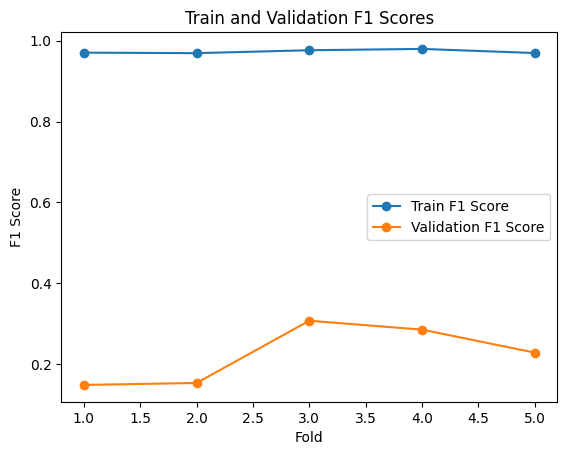

In [ ]:
# Save Cross-Validation Plot
if 'train_scores' in metrics and 'valid_scores' in metrics:
    plot_cross_validation_scores(
        metrics['train_scores'], metrics['valid_scores'])

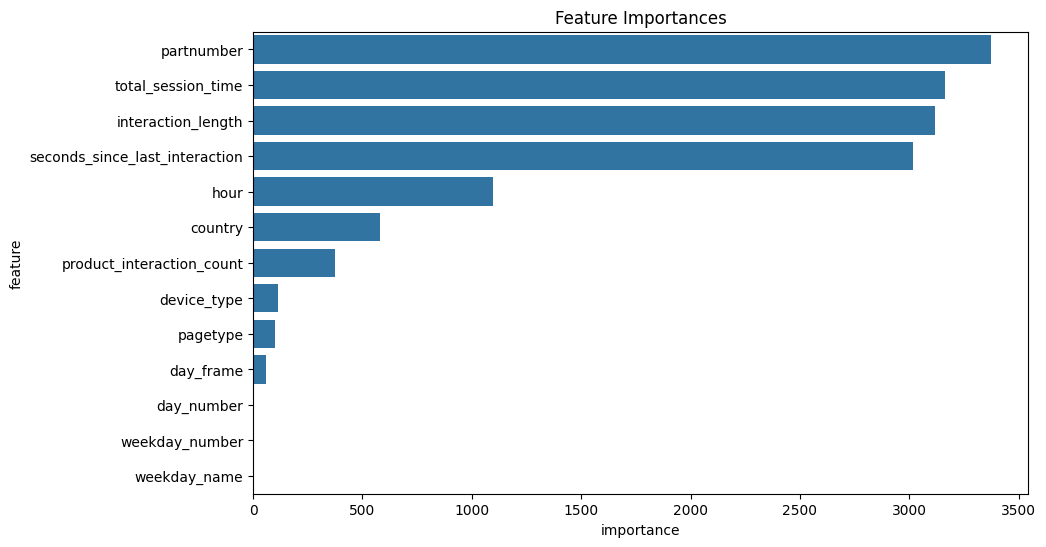

In [13]:
estimator.fit(X, y)
plot_feature_importances(estimator, FEATURES)